# Capstone-The-Battle-of-Neighborhood

The final project for the IBM capstone course

# Main Questions:

It is well known that New York City is the center of midwest and food there is really good. As a Asian student nearby, I really like to take bus to the city for a good meal on weekend. At this time, I want to use the knowledge I learned here to solve the following questions: 

‚Ä¢ What is the best location to enjoy Asian food in NYC?

‚Ä¢ Is it a good idea to open a Asian restaurant in NYC now?

P.S In case I get to much information later in data processing, I limit the Asian restaurant for only Thai restaurant.

# Methodology

‚Ä¢ Data will be collected from https://geo.nyu.edu/catalog/nyu-2451-34572, which has been used as an example before, and cleaned and processed into a dataframe.

‚Ä¢ FourSquare be used to locate all venues and then filtered by Asian food restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

‚Ä¢ Data will be sorted based on rankings and be visually assessed by using graphing from Python libraries.

In [2]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests 
import json
from bs4 import BeautifulSoup
import os

! pip install folium==0.5.0 
import folium 

! pip install geopy
from geopy.geocoders import Nominatim 
import requests 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries loaded done')

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 79 kB 7.9 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=93821bf5b92e9c263a35909a55c29bbb95e51963b2488fe74f6e96b6a7650bde
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Libraries loaded done


In [3]:
CLIENT_ID = '5ISLCUZRLCCZ4M0K4BIRVA2F1TPDI3MX1B2U1MIZI0SMGBDM' # your Foursquare ID
CLIENT_SECRET = 'BQRRDJD20RLJFCV2JAOTSU5PAISMR5Y2MO4SFOBC0W5LTONO ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ISLCUZRLCCZ4M0K4BIRVA2F1TPDI3MX1B2U1MIZI0SMGBDM
CLIENT_SECRET:BQRRDJD20RLJFCV2JAOTSU5PAISMR5Y2MO4SFOBC0W5LTONO 


In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=500
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    
    features=resp['features']

    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [6]:
ny_data = get_new_york_data()
ny_data.head()


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

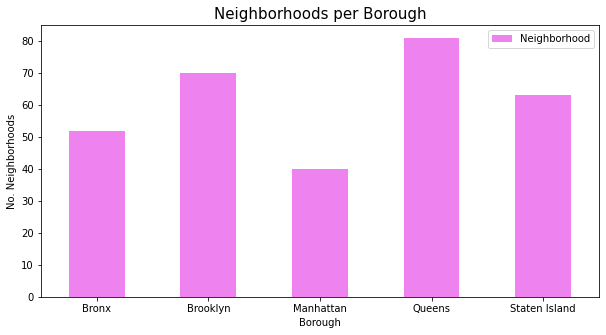

In [7]:
clr = "violet"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough', fontsize = 15)
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('No. Neighborhoods',fontsize = 10)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [22]:
ny_data.values.tolist()

[['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902],
 ['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398],
 ['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412],
 ['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682],
 ['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857],
 ['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604],
 ['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981],
 ['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176],
 ['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681],
 ['Bronx', 'Williamsbridge', 40.88103887819211, -73.85744642974207],
 ['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117],
 ['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999],
 ['Bronx', 'City Island', 40.84724670491813, -73.78648845267413],
 ['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913],
 ['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131],
 ['Bronx',

In [22]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
as_rest_ny=pd.DataFrame(columns=column_names)
i=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    asian_restaurants=venues[venues['Category']=='Thai Restaurant']   
    print('(',i,'/',len(ny_data),')','Asian Restaurant in '+Neighborhood+', '+Borough+':'+str(len(asian_restaurants)))
    print(row)
    for resturant_detail in asian_restaurants.values.tolist():
        id, name , category=resturant_detail
        as_rest_ny = as_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    i = i + 1

as_rest_ny.to_csv('as_rest_ny_tocsv1.csv')
as_rest_ny = pd.read_csv('as_rest_ny_tocsv1.csv')
as_rest_ny.head(10)

( 1 / 306 ) Asian Restaurant in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Asian Restaurant in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Asian Restaurant in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Asian Restaurant in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Asian Restaurant in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Asian Restaurant in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Asian Restaurant in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Asian Restaurant in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Asian Restaurant in Norwood, Bronx:0
['Bronx', 'Norwood', 40.87722

Unnamed: 0   Borough      Neighborhood                        ID  \
0           0     Bronx    Spuyten Duyvil  4a739e29f964a520f5dc1fe3   
1           1     Bronx        Pelham Bay  4b4c90d3f964a52046b626e3   
2           2  Brooklyn         Bay Ridge  50e8d45ae4b06202fbe39b08   
3           3  Brooklyn         Bay Ridge  4c1993344ff90f474d421049   
4           4  Brooklyn        Kensington  4b36a0f5f964a5207b3925e3   
5           5  Brooklyn        Kensington  54daa265498e58e310cae373   
6           6  Brooklyn  Prospect Heights  57117904498eea6297e41d0a   
7           7  Brooklyn  Prospect Heights  56773ac0498e301585915c6f   
8           8  Brooklyn  Prospect Heights  58fe480bda708012683cda5f   
9           9  Brooklyn  Brooklyn Heights  476f8da1f964a520044d1fe3   

                       Name  
0               Siam Square  
1     Honey's Thai Pavilion  
2                  Top Thai  
3             Bangkok Tokyo  
4                To Be Thai  
5      Sawasde Thai Cooking  
6                      Muse  
7  LOOK by Plant Love House  
8   Nourish Thai Food Oasis  
9      Lantern Thai Kitchen

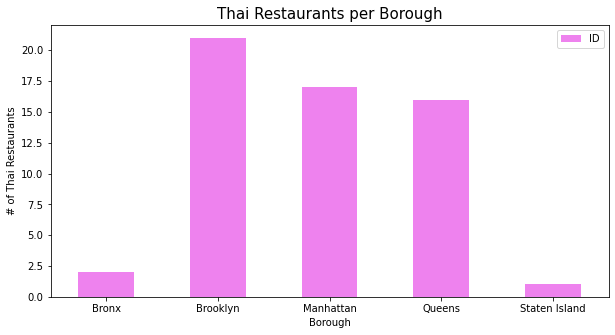

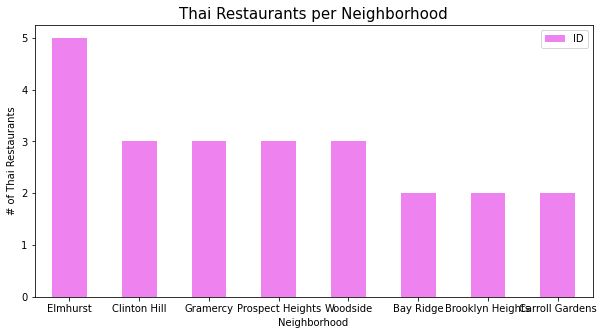

In [24]:
as_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Thai Restaurants per Borough', fontsize = 15)
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('# of Thai Restaurants', fontsize=10)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


NOofNeigh = 8 # top number for graphing all the same past 8
as_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Thai Restaurants per Neighborhood', fontsize = 15)
plt.xlabel('Neighborhood', fontsize = 10)
plt.ylabel('# of Thai Restaurants', fontsize=10)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [39]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
as_rest_stats_ny=pd.DataFrame(columns=column_names)
i = 1
for row in as_rest_ny.values.tolist():
    index,Borough,Neighborhood,ID,Name=row
    print(Borough)
    print(Neighborhood)
    print(ID)
    print(Name)
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',i,'/',len(as_rest_ny),')','processed')
    as_rest_stats_ny = as_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    i = i + 1
    
as_rest_stats_ny.tail()
as_rest_stats_ny.to_csv('as_rest_stats_ny_csv.csv')
as_rest_stats_ny.info()

Bronx
Spuyten Duyvil
4a739e29f964a520f5dc1fe3
Siam Square
{'meta': {'code': 200, 'requestId': '5f9d933a6304202de9b49365'}, 'response': {'venue': {'id': '4a739e29f964a520f5dc1fe3', 'name': 'Siam Square', 'contact': {'phone': '7184328200', 'formattedPhone': '(718) 432-8200'}, 'location': {'address': '564 Kappock St', 'lat': 40.8787962348852, 'lng': -73.91670090763066, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8787962348852, 'lng': -73.91670090763066}, {'label': 'entrance', 'lat': 40.878772, 'lng': -73.916958}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['564 Kappock St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/siam-square/4a739e29f964a520f5dc1fe3', 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, '

In [40]:
as_rest_stats_ny['Likes'] = as_rest_stats_ny['Likes'].astype('float64')
as_rest_stats_ny['Tips'] = as_rest_stats_ny['Tips'].astype('float64')
as_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       57 non-null     object 
 1   Neighborhood  57 non-null     object 
 2   ID            57 non-null     object 
 3   Name          57 non-null     object 
 4   Likes         57 non-null     float64
 5   Rating        57 non-null     float64
 6   Tips          57 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.2+ KB


In [37]:
row

[0, 'Bronx', 'Spuyten Duyvil', '4a739e29f964a520f5dc1fe3', 'Siam Square']

In [41]:
as_rest_stats_ny.describe()

Likes     Rating        Tips
count   57.000000  57.000000   57.000000
mean    83.263158   7.733333   31.017544
std    147.103162   1.657056   56.188932
min      0.000000   0.000000    0.000000
25%     15.000000   7.500000    6.000000
50%     29.000000   8.000000   12.000000
75%     61.000000   8.600000   27.000000
max    768.000000   9.400000  358.000000

In [42]:
as_rest_stats_ny.iloc[as_rest_stats_ny['Likes'].idxmax()]
as_rest_stats_ny.iloc[as_rest_stats_ny['Rating'].idxmax()]
as_rest_stats_ny.iloc[as_rest_stats_ny['Tips'].idxmax()]


Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                768
Rating                               8.9
Tips                                 358
Name: 36, dtype: object

In [43]:
ny_neighborhood_stats=as_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
5         Chinatown             9.4
20     Little Italy             9.3
19       Lenox Hill             9.1
12         Flatiron             8.9
35        Yorkville             8.8
4   Carroll Gardens             8.7
24         Red Hook             8.6
15    Hunters Point             8.6
26       South Side             8.5
16  Jackson Heights             8.4

In [44]:
ny_borough_stats=as_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.300000
1       Brooklyn        7.614286
4  Staten Island        7.600000
3         Queens        7.350000
0          Bronx        7.300000

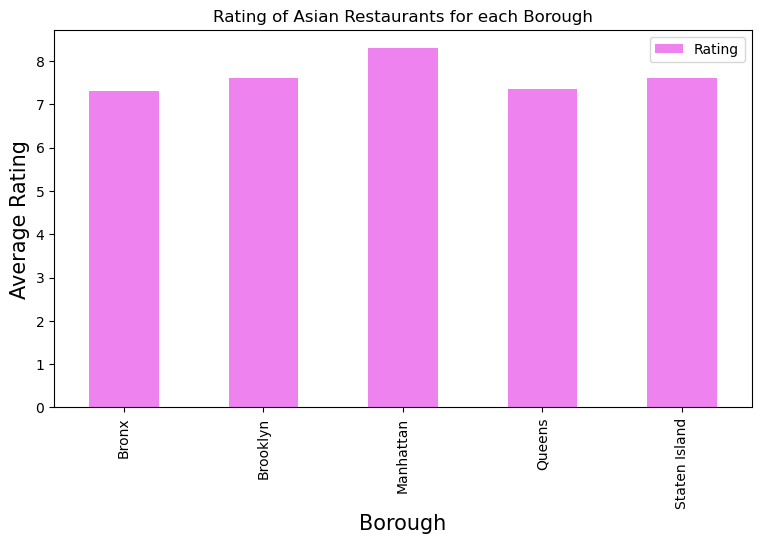

In [45]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Rating of Asian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
as_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [52]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Borough        Neighborhood   Latitude  Longitude  Average Rating
0        Brooklyn           Bay Ridge  40.625801 -74.030621        3.600000
1          Queens             Bayside  40.766041 -73.774274        7.200000
2        Brooklyn    Brooklyn Heights  40.695864 -73.993782        7.550000
3   Staten Island          Bulls Head  40.609592 -74.159409        7.600000
4        Brooklyn     Carroll Gardens  40.680540 -73.994654        8.700000
5       Manhattan           Chinatown  40.715618 -73.994279        9.400000
6        Brooklyn        Clinton Hill  40.693229 -73.967843        8.266667
7        Brooklyn         Cobble Hill  40.687920 -73.998561        7.300000
8        Brooklyn            Downtown  40.690844 -73.983463        8.250000
9       Manhattan         East Harlem  40.792249 -73.944182        8.200000
10       Brooklyn   East Williamsburg  40.708492 -73.938858        6.100000
11         Queens            Elmhurst  40.744049 -73.881656        8.180000
12      Manhattan            Flatiron  40.739673 -73.990947        8.900000
13       Brooklyn         Fort Greene  40.688527 -73.972906        7.500000
14      Manhattan            Gramercy  40.737210 -73.981376        7.533333
15         Queens       Hunters Point  40.743414 -73.953868        8.600000
16         Queens     Jackson Heights  40.751981 -73.882821        8.400000
17         Queens       Jamaica Hills  40.711460 -73.796465        6.900000
18       Brooklyn          Kensington  40.642382 -73.980421        8.000000
19      Manhattan          Lenox Hill  40.768113 -73.958860        9.100000
20      Manhattan        Little Italy  40.719324 -73.997305        9.300000
21         Queens    Long Island City  40.750217 -73.939202        7.600000
22          Bronx          Pelham Bay  40.850641 -73.832074        7.500000
23       Brooklyn    Prospect Heights  40.676822 -73.964859        8.300000
24       Brooklyn            Red Hook  40.676253 -74.012759        8.600000
25         Queens           Ridgewood  40.708323 -73.901435        0.000000
26       Brooklyn          South Side  40.710861 -73.958001        8.500000
27          Bronx      Spuyten Duyvil  40.881395 -73.917190        7.100000
28         Queens   Sunnyside Gardens  40.745652 -73.918193        7.600000
29      Manhattan        Sutton Place  40.760280 -73.963556        7.800000
30      Manhattan          Turtle Bay  40.752042 -73.967708        7.600000
31      Manhattan     Upper West Side  40.787658 -73.977059        8.150000
32      Manhattan  Washington Heights  40.851903 -73.936900        6.900000
33         Queens           Woodhaven  40.689887 -73.858110        6.400000
34         Queens            Woodside  40.746349 -73.901842        8.000000
35      Manhattan           Yorkville  40.775930 -73.947118        8.800000

In [75]:
#mapping it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
       rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, 
            color='blue',
            fill=True,
            fill_color='red',
            fill_opacity=1
        )
      )

ny_map.add_child(rating)

In [65]:
rating = folium.map.FeatureGroup()
